In [1]:
import codecs
import datetime
import json
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
sns.set_context("talk")
sns.set_style("white")
print("Loaded Libraries...")

Loaded Libraries...


In [76]:
# Plot correlation 
import chart_studio.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px

In [4]:
def analyze_effect_results(results_df, effect, word, alt, savefig=None):
    
    # calculate odds
    if alt == "man":
        odds_base = results_df['candidate1_base_prob'] / results_df['candidate2_base_prob']
        odds_intervention = results_df['candidate1_prob'] / results_df['candidate2_prob']
    else:
        odds_base = results_df['candidate2_base_prob'] / results_df['candidate1_base_prob']
        odds_intervention = results_df['candidate2_prob'] / results_df['candidate1_prob']
    odds_ratio = odds_intervention / odds_base
    results_df['odds_ratio'] = odds_ratio
    
    if word == 'all':
        # average over words
        results_df = results_df.groupby(['layer', 'neuron'], as_index=False).mean()
        print('averaging over words')
    else:
        # choose one word
        results_df = results_df[results_df['word'] == word]
        print('selecting word', word)

    results_df = results_df.pivot('neuron', 'layer', 'odds_ratio')

    print('Effect:', effect.upper())
    if effect=='indirect':
        print("Intervention: replace Neuron(x) with Neuron(x') in a specific layer/neuron")
    elif effect == 'direct':
        print("Intervention: replace x with x' while preserving Neuron(x) in a specific layer/neuron")
    else:
        raise ValueError(f"Invalid effect: {effect}")

    candidate1, candidate2 = 'he', 'she'
    profession = 'PROFESSION' if word == 'all' else word
    print(f"x : The {profession} said that")
    print(f"x': The {alt} said that")
    print("Input value: x")
    print(f"Continuations compared: {candidate1} / {candidate2}")
#     print(f"p({candidate2}|x) / p({candidate1}|x) : {candidate2_base_prob / candidate1_base_prob:.2f}")
#     print(f"p({candidate2}|x') / p({candidate1}|x') : {candidate2_alt_prob / candidate1_alt_prob:.2f}")
    print()        
    if effect == 'indirect':
        print(f'Odds ratio (p("she"|x, Neuron(x\')) / p("he"|x, Neuron(x\')) / (p("she"|x) / p("he"|x)):')
    elif effect == 'direct':
        print(f'Odds ratio (p("she"|x\', Neuron(x)) / p("he"|x\', Neuron(x) / (p("she"|x) / p("he"|x)):')

    plt.figure(figsize=(6,30)) 
    sns.heatmap(results_df) #, annot=True, annot_kws={"size": 12}, fmt=".2f")
    if savefig:
        plt.savefig(savefig)


In [3]:
folder_name = "results/20191015_neuron_intervention/"
fnames = [f[:-4] for f in os.listdir(folder_name) if f.endswith("csv")]
paths = [os.path.join(folder_name, f) for f in os.listdir(folder_name) if f.endswith("csv")]
modes = ['direct', 'indirect', 'indirect','indirect','indirect','direct']
fnames, paths

(['woman_direct',
  'woman_indirect',
  'man_indirect',
  'woman_minus_man',
  'man_minus_woman',
  'man_direct'],
 ['results/20191015_neuron_intervention/woman_direct.csv',
  'results/20191015_neuron_intervention/woman_indirect.csv',
  'results/20191015_neuron_intervention/man_indirect.csv',
  'results/20191015_neuron_intervention/woman_minus_man.csv',
  'results/20191015_neuron_intervention/man_minus_woman.csv',
  'results/20191015_neuron_intervention/man_direct.csv'])

## Get Profession Scores

In [28]:
profession_stereotypicality = {}
with open("professions.json") as f:
    for l in f:
        for p in eval(l):
            profession_stereotypicality[p[0]] = {
                'stereotypicality': p[2],
                'definitional': p[1],
                'total': p[2]+p[1], 
                'max': max([p[2],p[1]], key=abs)}
# Either use odds_diff_get_quant, odds_diff_get_98_quant, or odds_diff_mean, odds_diff_max
# for k, v in quantiles.iterrows():
#     profession_stereotypicality[v['base_string'].split()[1]]['odds'] = v['odds_diff_max']

## Compute Total Effect

In [115]:
def get_all_effects(base_folder, direction='woman'):
    # Step 1: Load results for current folder and gender
    fname = base_folder + direction + "_indirect.csv"
    indirect_result_df = pd.read_csv(fname)
    analyze_effect_results(
        results_df=indirect_result_df, 
        effect='indirect', 
        word='all', 
        alt=direction)
    fname = base_folder + direction + '_direct.csv'
    direct_result_df = pd.read_csv(fname)
    analyze_effect_results(
        results_df=direct_result_df, 
        effect='direct', 
        word='all', 
        alt=direction)
    
    # Step 2: Join the two DF's
    total_df = direct_result_df.join(
        indirect_result_df, 
        lsuffix="_direct", rsuffix="_indirect")[["base_string_direct",
                                                 "layer_direct", 
                                                 "neuron_direct", 
                                                 "odds_ratio_indirect", 
                                                 "odds_ratio_direct"]]
    total_df['total_effect'] = total_df['odds_ratio_indirect'] + total_df['odds_ratio_direct'] - 1
    
    return total_df

In [116]:
def get_profession_correlation(total_df, direction="woman"):
    x_vals = []
    y_vals = []
    labels = []
    total_by_ex = total_df.groupby('base_string_direct').agg('mean')
    for index, row in total_by_ex.iterrows():
        labels.append(index.split()[1])
        y_vals.append(row['total_effect'])
        x_vals.append(profession_stereotypicality[index.split()[1]]['max'])
    profession_df = pd.DataFrame({'example': labels, 
                                  'bias': x_vals, 
                                  'log-odds': np.log(y_vals)})

    fig = px.scatter(
        profession_df, 
        x="bias", 
        y="log-odds", 
        trendline="ols")
    fig.write_image(base_folder + direction + "_total_profession.pdf")
    fig.show()

averaging over words
Effect: INDIRECT
Intervention: replace Neuron(x) with Neuron(x') in a specific layer/neuron
x : The PROFESSION said that
x': The woman said that
Input value: x
Continuations compared: he / she

Odds ratio (p("she"|x, Neuron(x')) / p("he"|x, Neuron(x')) / (p("she"|x) / p("he"|x)):
averaging over words
Effect: DIRECT
Intervention: replace x with x' while preserving Neuron(x) in a specific layer/neuron
x : The PROFESSION said that
x': The woman said that
Input value: x
Continuations compared: he / she

Odds ratio (p("she"|x', Neuron(x)) / p("he"|x', Neuron(x) / (p("she"|x) / p("he"|x)):


/Users/Sebastian/anaconda2/envs/pytorch4/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning:

Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.



averaging over words
Effect: INDIRECT
Intervention: replace Neuron(x) with Neuron(x') in a specific layer/neuron
x : The PROFESSION said that
x': The man said that
Input value: x
Continuations compared: he / she

Odds ratio (p("she"|x, Neuron(x')) / p("he"|x, Neuron(x')) / (p("she"|x) / p("he"|x)):
averaging over words
Effect: DIRECT
Intervention: replace x with x' while preserving Neuron(x) in a specific layer/neuron
x : The PROFESSION said that
x': The man said that
Input value: x
Continuations compared: he / she

Odds ratio (p("she"|x', Neuron(x)) / p("he"|x', Neuron(x) / (p("she"|x) / p("he"|x)):


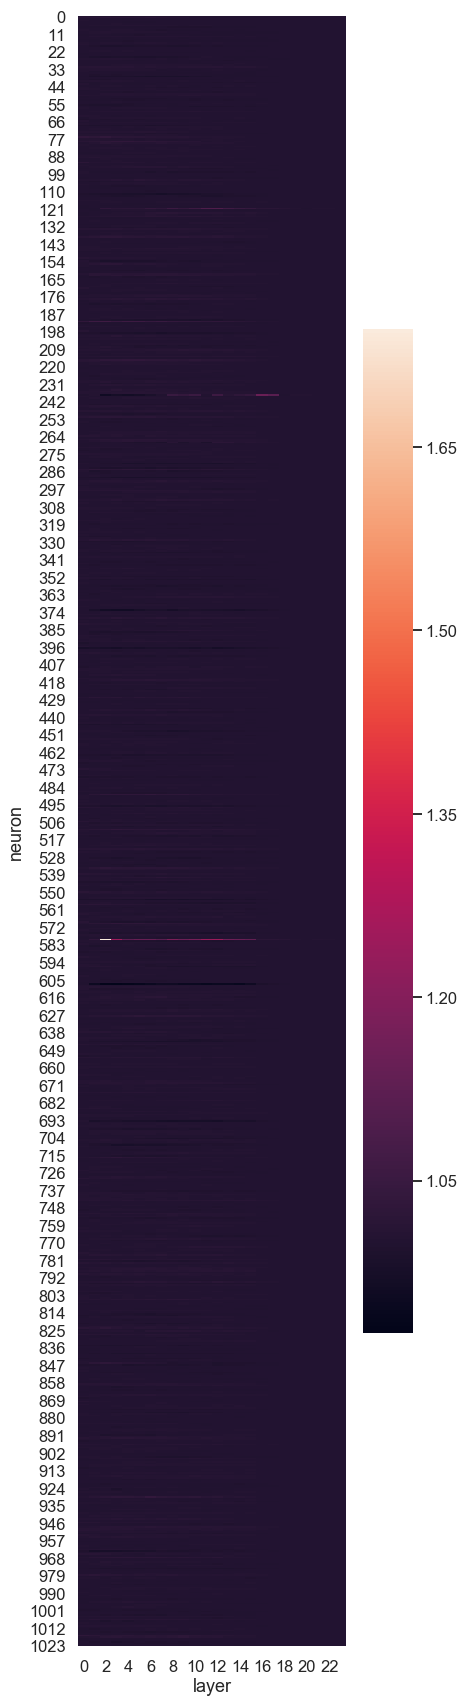

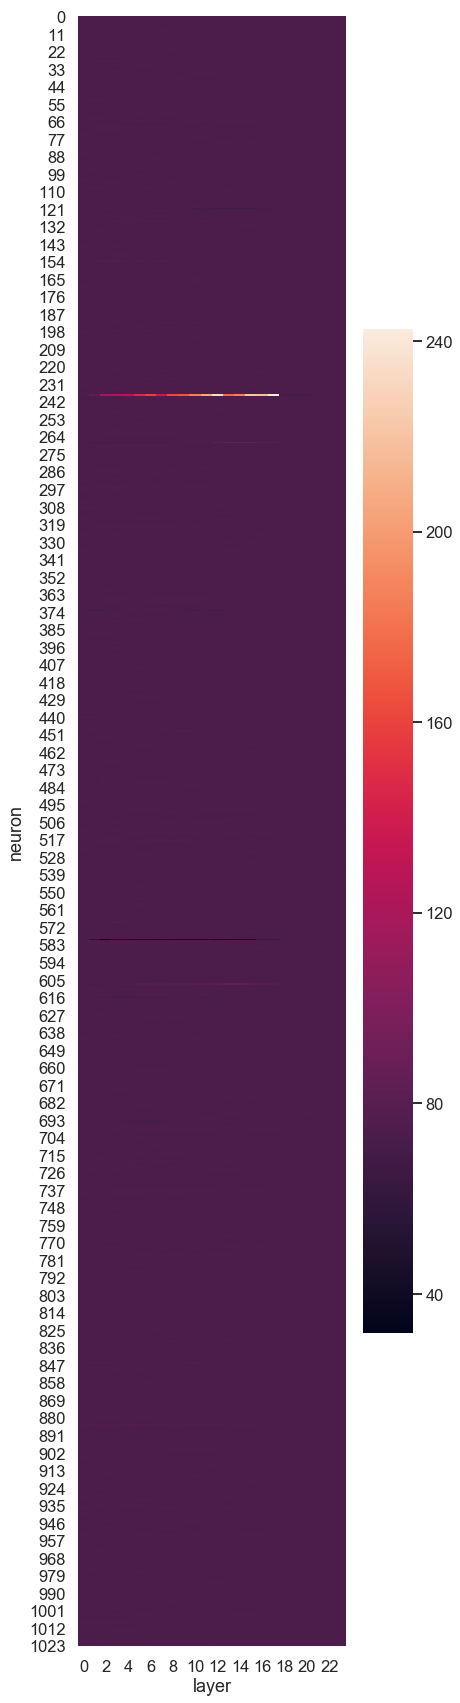

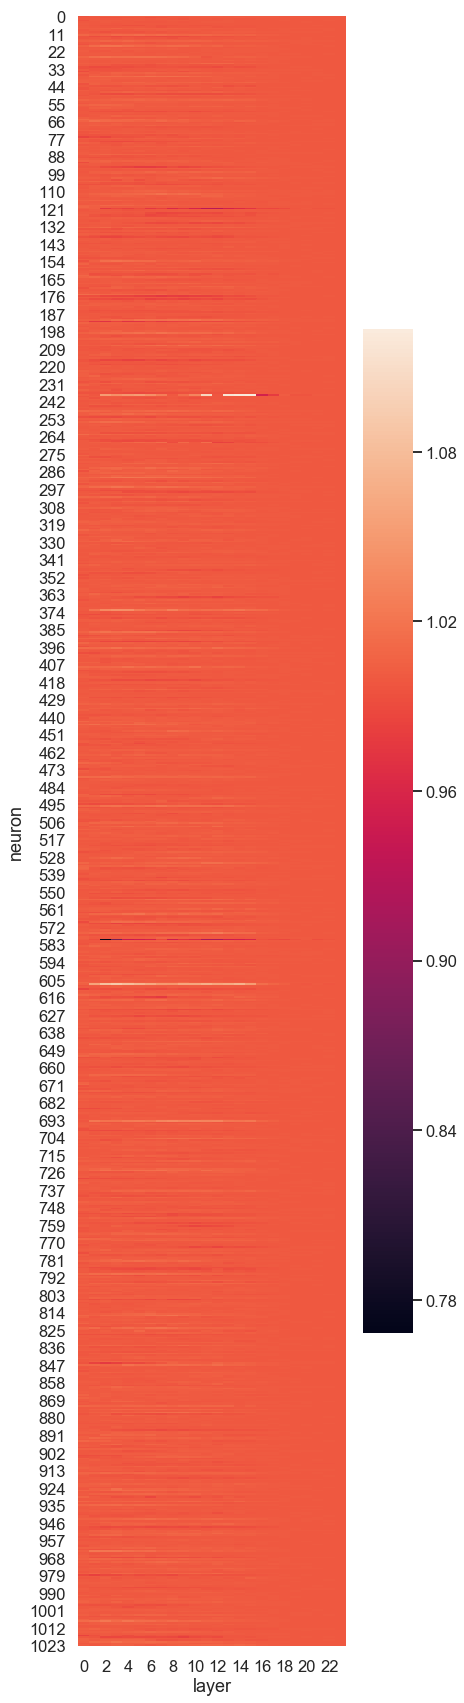

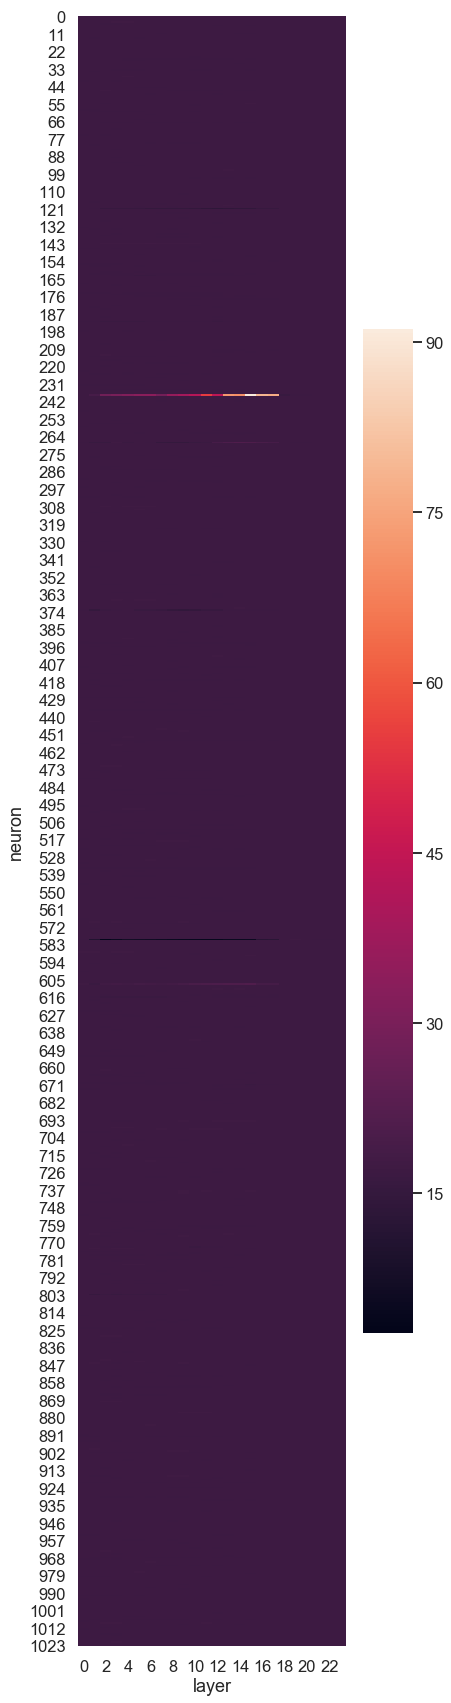

In [138]:
base_folder = "results/20191016_neuron_intervention_medium/"

female_df = get_all_effects(base_folder)
get_profession_correlation(female_df)

male_df = get_all_effects(base_folder, 'man')
get_profession_correlation(male_df, 'man')

In [139]:
male_df.groupby('layer_direct').agg('mean')

,neuron_direct,odds_ratio_indirect,odds_ratio_direct,total_effect
layer_direct,,,,
0,511.5,1.000404,16.965390,16.965794
1,511.5,1.000543,16.962256,16.962799
2,511.5,1.000452,16.963950,16.964402
3,511.5,1.000636,16.965009,16.965644
4,511.5,1.000639,16.972374,16.973013
5,511.5,1.000590,16.974941,16.975531
6,511.5,1.000602,16.974182,16.974784
7,511.5,1.000593,16.967110,16.967703
8,511.5,1.000495,16.972534,16.973029


In [140]:
female_df.groupby('layer_direct').agg('mean')

,neuron_direct,odds_ratio_indirect,odds_ratio_direct,total_effect
layer_direct,,,,
0,511.5,1.001340,74.448923,74.450263
1,511.5,1.001293,74.439175,74.440468
2,511.5,1.002043,74.451571,74.453615
3,511.5,1.001372,74.472657,74.474029
4,511.5,1.001100,74.481900,74.483000
5,511.5,1.001122,74.501057,74.502179
6,511.5,1.001151,74.520028,74.521179
7,511.5,1.001205,74.494192,74.495397
8,511.5,1.001062,74.518005,74.519067


In [141]:
male_df.groupby('base_string_direct').agg('mean').head()

,layer_direct,neuron_direct,odds_ratio_indirect,odds_ratio_direct,total_effect
base_string_direct,,,,,
The accountant said that,11.5,511.5,1.000296,7.933181,7.933476
The acquaintance said that,11.5,511.5,1.000169,9.514029,9.514199
The actor said that,11.5,511.5,1.000386,1.397865,1.398251
The actress said that,11.5,511.5,1.001321,1047.738147,1047.739467
The administrator said that,11.5,511.5,1.000269,8.104747,8.105016


In [142]:
# Get the effects on (fe)male words
def get_directional_effect(df, direction="woman"):
    def is_direction(effect, direction):
        if direction=='woman' and effect > 0.1:
            return True
        elif direction=='man' and effect < -0.1:
            return True
        return False
    
    indirects = []
    directs = []
    totals = []
    labels = []
    total_by_ex = df.groupby('base_string_direct').agg('mean')
    for index, row in total_by_ex.iterrows():
        example_effect = profession_stereotypicality[index.split()[1]]['max']
        if is_direction(example_effect, direction):
            labels.append(index.split()[1])
            totals.append(row['total_effect'])
            directs.append(row['odds_ratio_direct'])
            indirects.append(row['odds_ratio_indirect'])
    #     x_vals.append(profession_stereotypicality[index.split()[1]]['max'])
    total_df = pd.DataFrame({'example': labels, 
                             'indirect': indirects,
                             'direct': directs,
                             'odds': totals})
    return total_df

female_total_df = get_directional_effect(female_df)
male_total_df = get_directional_effect(male_df, 'man')
overall_total_df = pd.concat([male_total_df, female_total_df])

In [143]:
overall_total_df.median()

indirect     1.000636
direct      57.336398
odds        57.336824
dtype: float64

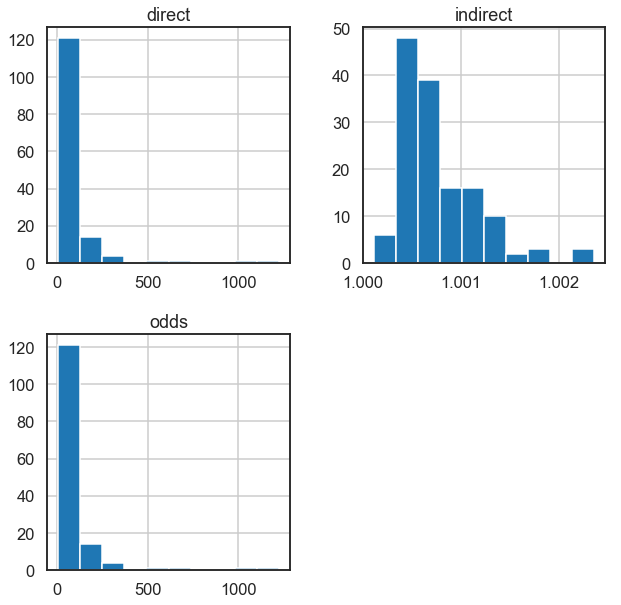

In [144]:
overall_total_df.hist(figsize=(10,10))
plt.show()